In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 6,078
training + validation N: 24,405


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,193,15,-0.074999,UUCGCGCCA
2,training,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA


In [3]:
# # load weights and set these weights to current additive gpmap to 
# # check whether x_to_phi is working correctly
# mpsa_theta = pd.read_csv('data/mpsa_ge_additive_theta.csv',index_col=[0])
# mpsa_theta

In [4]:
# # set positional argumnets for gpmap function
# L = len(data_df['x'][0])
# alphabet=['A','C','G','U']

In [5]:
# # instantiate gpmap object
# gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # set parameters to mpsa model 
# # this is done to check for validity of updated x_to_phi
# gpmap.set_params(theta_0=-2.508132402430794,
#                  theta_lc=mpsa_theta.values)

# # get test set data.
# x_test = test_df['x'].values
# y_test = test_df['y'].values

### Updated phi usage
Computed directly from gpmap object

In [6]:
# phi = gpmap.x_to_phi(x_test)

### Validate gpmap object usage

In [7]:
# fig, ax = plt.subplots(figsize=(4.5,4.5))
# ax.scatter(phi,y_test,s=3,alpha=0.2,c='b')
# ax.set_ylabel('y (test)')
# ax.set_xlabel('phi')

## Create new gpmap to test out with multi-target GE regression

In [8]:
L = len(data_df['x'][0])
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet=['A','C','G','T'])

2022-02-25 16:40:17.552658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [9]:
mp_GE_1 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=12)
mp_GE_2 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=10)


K is 12
K is 10


In [10]:
mp_GE_2.yhat._trainable_weights

[]

In [11]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_GE_1,mp_GE_2])

number targerts 2


In [12]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 38)]        0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 36)           0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer_1 (Addit  (None, 1)           37          ['Sequence_only[0][0]']          
 iveGPMapLayer)                                                                                   
                                                                                              

In [13]:
# to check if weights update before and after training
#mp_GE_1_GE_weights = mp_GE_1.yhat._trainable_weights[1].numpy().copy()

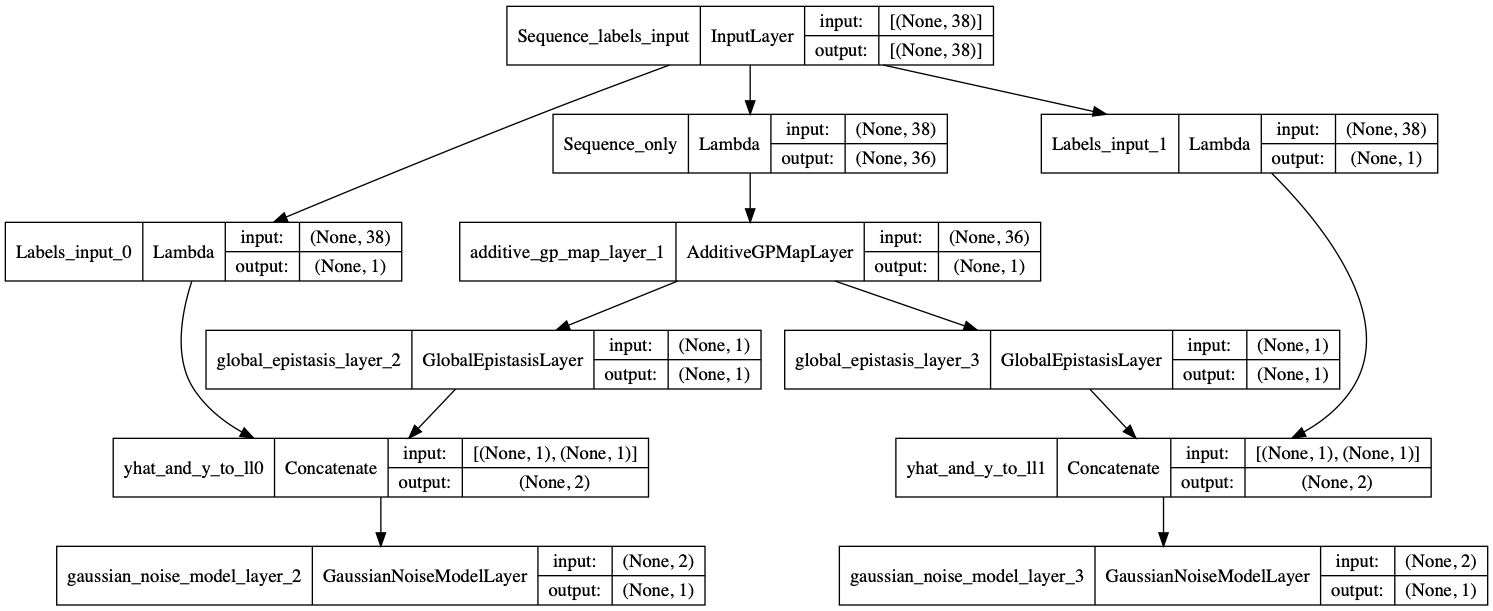

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False)

Each measurement can call it's specific $\phi$ to $y$ functions:

## Prepare data with two targets 
In this case two replicate PSI measurements for BRCA2

In [15]:
MPSA_data_lib1_rep1 = pd.read_csv('data/20.08.16_mpsa_data/brca2_lib1_rep1.csv')
MPSA_data_lib1_rep2 = pd.read_csv('data/20.08.16_mpsa_data/brca2_lib1_rep2.csv')

In [16]:
#BRCA_df = MPSA_data_lib1_rep1.merge(MPSA_data_lib1_rep3,on='ss',how='outer')
BRCA_df = MPSA_data_lib1_rep1.merge(MPSA_data_lib1_rep2,on='ss',how='outer').copy()
BRCA_df = BRCA_df[['ss', 'log_psi_x', 'log_psi_y']].copy()
BRCA_df.columns = ['x','y1','y2']

# drop nans for now, though in future this should be allowed. 
BRCA_df.dropna(inplace=True)

# split into train-val-test sets. 
np.random.seed(777)
BRCA_df['set'] = np.random.choice(a=['training', 'validation', 'test'], 
                                   p=[.8,.1,.1], 
                                   size=len(BRCA_df))
BRCA_df

,x,y1,y2,set
0,AAAGCAAAA,-3.751854,-3.115981,training
1,AAAGCAAAC,-2.697741,-2.991176,training
2,AAAGCAAAG,-2.242947,-2.666159,training
3,AAAGCAAAT,-3.067251,-2.823078,training
4,AAAGCAACA,-2.987074,-2.489996,validation
...,...,...,...,...
21924,TTTGTTTCT,-3.265759,-3.776585,training
21925,TTTGTTTGA,-2.729585,-3.509597,training
21926,TTTGTTTGG,-2.944439,-3.079346,validation
21927,TTTGTTTGT,-3.267212,-3.325882,training


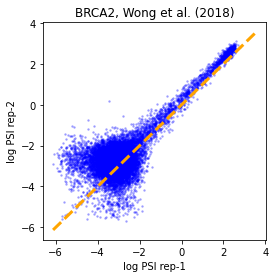

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(BRCA_df['y1'],BRCA_df['y2'],s=2.5,color='blue',alpha=0.25)
ax.set_xlabel('log PSI rep-1')
ax.set_ylabel('log PSI rep-2')
ax.set_title('BRCA2, Wong et al. (2018)')
lims = ax.get_ylim()
ax.plot(lims,lims,linestyle='--',color='orange',lw=3)

In [18]:
# Separate test from data_df
ix_test = BRCA_df['set']=='test'
test_df = BRCA_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

test N: 2,104


## Set data 

In [19]:
# Set training data
model.set_data(x=BRCA_df['x'],
               y=BRCA_df[['y1','y2']],
               validation_flags=(BRCA_df['set']=='validation'),
               shuffle=False)

N = 21,466 observations set as training data.
Using 9.8% for validation.
Time to set data: 0.134 sec.


In [20]:
model.y_norm

,y1,y2
0,-3.751854,-3.115981
1,-2.697741,-2.991176
2,-2.242947,-2.666159
3,-3.067251,-2.823078
4,-2.987074,-2.489996
...,...,...
21924,-3.265759,-3.776585
21925,-2.729585,-3.509597
21926,-2.944439,-3.079346
21927,-3.267212,-3.325882


Note that linear initialization currently won't work with more than one y target

In [21]:
# # Fit model to data
# history = model.fit(learning_rate=.0005,
#                     epochs=1,
#                     batch_size=50,
#                     early_stopping=True,
#                     linear_initialization=False)


# Fit model to data
history = model.fit(learning_rate=.0001,
                    epochs=1000,
                    batch_size=100,
                    early_stopping=True,
                    early_stopping_patience=30,
                    linear_initialization=False)

fit
(19373, 2)
Epoch 1/1000
194/194 [==============================] - 2s 3ms/step - loss: 560.6924 - gaussian_noise_model_layer_2_loss: 277.0107 - gaussian_noise_model_layer_3_loss: 283.6810 - I_var: nan - val_loss: 486.2267 - val_gaussian_noise_model_layer_2_loss: 240.9104 - val_gaussian_noise_model_layer_3_loss: 245.3151 - val_I_var: nan
Epoch 2/1000
194/194 [==============================] - 0s 2ms/step - loss: 434.7674 - gaussian_noise_model_layer_2_loss: 216.0421 - gaussian_noise_model_layer_3_loss: 218.7241 - I_var: nan - val_loss: 406.3546 - val_gaussian_noise_model_layer_2_loss: 202.4972 - val_gaussian_noise_model_layer_3_loss: 203.8562 - val_I_var: nan
Epoch 3/1000
194/194 [==============================] - 0s 2ms/step - loss: 381.6901 - gaussian_noise_model_layer_2_loss: 190.4765 - gaussian_noise_model_layer_3_loss: 191.2126 - I_var: nan - val_loss: 373.7932 - val_gaussian_noise_model_layer_2_loss: 186.6974 - val_gaussian_noise_model_layer_3_loss: 187.0947 - val_I_var: nan
E

Epoch 26/1000
194/194 [==============================] - 0s 2ms/step - loss: 292.8779 - gaussian_noise_model_layer_2_loss: 146.4419 - gaussian_noise_model_layer_3_loss: 146.4351 - I_var: nan - val_loss: 296.6225 - val_gaussian_noise_model_layer_2_loss: 148.3111 - val_gaussian_noise_model_layer_3_loss: 148.3104 - val_I_var: nan
Epoch 27/1000
194/194 [==============================] - 0s 2ms/step - loss: 291.0695 - gaussian_noise_model_layer_2_loss: 145.5378 - gaussian_noise_model_layer_3_loss: 145.5307 - I_var: nan - val_loss: 294.6711 - val_gaussian_noise_model_layer_2_loss: 147.3359 - val_gaussian_noise_model_layer_3_loss: 147.3342 - val_I_var: nan
Epoch 28/1000
194/194 [==============================] - 0s 2ms/step - loss: 289.2292 - gaussian_noise_model_layer_2_loss: 144.6177 - gaussian_noise_model_layer_3_loss: 144.6104 - I_var: nan - val_loss: 292.6631 - val_gaussian_noise_model_layer_2_loss: 146.3324 - val_gaussian_noise_model_layer_3_loss: 146.3297 - val_I_var: nan
Epoch 29/1000

Epoch 51/1000
194/194 [==============================] - 0s 2ms/step - loss: 242.7520 - gaussian_noise_model_layer_2_loss: 121.3791 - gaussian_noise_model_layer_3_loss: 121.3714 - I_var: nan - val_loss: 241.9177 - val_gaussian_noise_model_layer_2_loss: 120.9623 - val_gaussian_noise_model_layer_3_loss: 120.9538 - val_I_var: nan
Epoch 52/1000
194/194 [==============================] - 0s 2ms/step - loss: 241.3384 - gaussian_noise_model_layer_2_loss: 120.6722 - gaussian_noise_model_layer_3_loss: 120.6645 - I_var: nan - val_loss: 240.4425 - val_gaussian_noise_model_layer_2_loss: 120.2247 - val_gaussian_noise_model_layer_3_loss: 120.2162 - val_I_var: nan
Epoch 53/1000
194/194 [==============================] - 0s 2ms/step - loss: 239.9492 - gaussian_noise_model_layer_2_loss: 119.9777 - gaussian_noise_model_layer_3_loss: 119.9700 - I_var: nan - val_loss: 239.0476 - val_gaussian_noise_model_layer_2_loss: 119.5272 - val_gaussian_noise_model_layer_3_loss: 119.5188 - val_I_var: nan
Epoch 54/1000

Epoch 76/1000
194/194 [==============================] - 0s 2ms/step - loss: 225.9993 - gaussian_noise_model_layer_2_loss: 112.9999 - gaussian_noise_model_layer_3_loss: 112.9967 - I_var: nan - val_loss: 225.3655 - val_gaussian_noise_model_layer_2_loss: 112.6830 - val_gaussian_noise_model_layer_3_loss: 112.6799 - val_I_var: nan
Epoch 77/1000
194/194 [==============================] - 0s 2ms/step - loss: 225.8100 - gaussian_noise_model_layer_2_loss: 112.9052 - gaussian_noise_model_layer_3_loss: 112.9022 - I_var: nan - val_loss: 225.1462 - val_gaussian_noise_model_layer_2_loss: 112.5732 - val_gaussian_noise_model_layer_3_loss: 112.5703 - val_I_var: nan
Epoch 78/1000
194/194 [==============================] - 0s 2ms/step - loss: 225.7777 - gaussian_noise_model_layer_2_loss: 112.8889 - gaussian_noise_model_layer_3_loss: 112.8861 - I_var: nan - val_loss: 224.9860 - val_gaussian_noise_model_layer_2_loss: 112.4930 - val_gaussian_noise_model_layer_3_loss: 112.4903 - val_I_var: nan
Epoch 79/1000

Epoch 101/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.8158 - gaussian_noise_model_layer_2_loss: 111.9063 - gaussian_noise_model_layer_3_loss: 111.9059 - I_var: nan - val_loss: 222.9335 - val_gaussian_noise_model_layer_2_loss: 111.4651 - val_gaussian_noise_model_layer_3_loss: 111.4649 - val_I_var: nan
Epoch 102/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.7719 - gaussian_noise_model_layer_2_loss: 111.8844 - gaussian_noise_model_layer_3_loss: 111.8840 - I_var: nan - val_loss: 222.9629 - val_gaussian_noise_model_layer_2_loss: 111.4798 - val_gaussian_noise_model_layer_3_loss: 111.4796 - val_I_var: nan
Epoch 103/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.7416 - gaussian_noise_model_layer_2_loss: 111.8691 - gaussian_noise_model_layer_3_loss: 111.8689 - I_var: nan - val_loss: 222.8591 - val_gaussian_noise_model_layer_2_loss: 111.4278 - val_gaussian_noise_model_layer_3_loss: 111.4277 - val_I_var: nan
Epoch 104/

Epoch 126/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.4183 - gaussian_noise_model_layer_2_loss: 111.7071 - gaussian_noise_model_layer_3_loss: 111.7072 - I_var: nan - val_loss: 222.3634 - val_gaussian_noise_model_layer_2_loss: 111.1796 - val_gaussian_noise_model_layer_3_loss: 111.1799 - val_I_var: nan
Epoch 127/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.3938 - gaussian_noise_model_layer_2_loss: 111.6948 - gaussian_noise_model_layer_3_loss: 111.6950 - I_var: nan - val_loss: 222.3442 - val_gaussian_noise_model_layer_2_loss: 111.1700 - val_gaussian_noise_model_layer_3_loss: 111.1702 - val_I_var: nan
Epoch 128/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.4473 - gaussian_noise_model_layer_2_loss: 111.7216 - gaussian_noise_model_layer_3_loss: 111.7218 - I_var: nan - val_loss: 222.5391 - val_gaussian_noise_model_layer_2_loss: 111.2674 - val_gaussian_noise_model_layer_3_loss: 111.2677 - val_I_var: nan
Epoch 129/

Epoch 151/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.3259 - gaussian_noise_model_layer_2_loss: 111.6607 - gaussian_noise_model_layer_3_loss: 111.6609 - I_var: nan - val_loss: 222.1711 - val_gaussian_noise_model_layer_2_loss: 111.0833 - val_gaussian_noise_model_layer_3_loss: 111.0836 - val_I_var: nan
Epoch 152/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2899 - gaussian_noise_model_layer_2_loss: 111.6428 - gaussian_noise_model_layer_3_loss: 111.6429 - I_var: nan - val_loss: 222.1499 - val_gaussian_noise_model_layer_2_loss: 111.0727 - val_gaussian_noise_model_layer_3_loss: 111.0730 - val_I_var: nan
Epoch 153/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2716 - gaussian_noise_model_layer_2_loss: 111.6336 - gaussian_noise_model_layer_3_loss: 111.6338 - I_var: nan - val_loss: 222.1404 - val_gaussian_noise_model_layer_2_loss: 111.0679 - val_gaussian_noise_model_layer_3_loss: 111.0682 - val_I_var: nan
Epoch 154/

Epoch 176/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.3115 - gaussian_noise_model_layer_2_loss: 111.6535 - gaussian_noise_model_layer_3_loss: 111.6536 - I_var: nan - val_loss: 222.0791 - val_gaussian_noise_model_layer_2_loss: 111.0372 - val_gaussian_noise_model_layer_3_loss: 111.0374 - val_I_var: nan
Epoch 177/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1980 - gaussian_noise_model_layer_2_loss: 111.5967 - gaussian_noise_model_layer_3_loss: 111.5968 - I_var: nan - val_loss: 222.1249 - val_gaussian_noise_model_layer_2_loss: 111.0601 - val_gaussian_noise_model_layer_3_loss: 111.0603 - val_I_var: nan
Epoch 178/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2766 - gaussian_noise_model_layer_2_loss: 111.6360 - gaussian_noise_model_layer_3_loss: 111.6361 - I_var: nan - val_loss: 222.0621 - val_gaussian_noise_model_layer_2_loss: 111.0287 - val_gaussian_noise_model_layer_3_loss: 111.0290 - val_I_var: nan
Epoch 179/

Epoch 201/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2644 - gaussian_noise_model_layer_2_loss: 111.6298 - gaussian_noise_model_layer_3_loss: 111.6300 - I_var: nan - val_loss: 222.0049 - val_gaussian_noise_model_layer_2_loss: 111.0001 - val_gaussian_noise_model_layer_3_loss: 111.0002 - val_I_var: nan
Epoch 202/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2783 - gaussian_noise_model_layer_2_loss: 111.6368 - gaussian_noise_model_layer_3_loss: 111.6369 - I_var: nan - val_loss: 221.9822 - val_gaussian_noise_model_layer_2_loss: 110.9887 - val_gaussian_noise_model_layer_3_loss: 110.9889 - val_I_var: nan
Epoch 203/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2570 - gaussian_noise_model_layer_2_loss: 111.6262 - gaussian_noise_model_layer_3_loss: 111.6263 - I_var: nan - val_loss: 222.0605 - val_gaussian_noise_model_layer_2_loss: 111.0279 - val_gaussian_noise_model_layer_3_loss: 111.0280 - val_I_var: nan
Epoch 204/

Epoch 226/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2107 - gaussian_noise_model_layer_2_loss: 111.6030 - gaussian_noise_model_layer_3_loss: 111.6031 - I_var: nan - val_loss: 221.9654 - val_gaussian_noise_model_layer_2_loss: 110.9803 - val_gaussian_noise_model_layer_3_loss: 110.9804 - val_I_var: nan
Epoch 227/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1301 - gaussian_noise_model_layer_2_loss: 111.5627 - gaussian_noise_model_layer_3_loss: 111.5628 - I_var: nan - val_loss: 221.9621 - val_gaussian_noise_model_layer_2_loss: 110.9786 - val_gaussian_noise_model_layer_3_loss: 110.9788 - val_I_var: nan
Epoch 228/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2497 - gaussian_noise_model_layer_2_loss: 111.6225 - gaussian_noise_model_layer_3_loss: 111.6225 - I_var: nan - val_loss: 221.9771 - val_gaussian_noise_model_layer_2_loss: 110.9862 - val_gaussian_noise_model_layer_3_loss: 110.9863 - val_I_var: nan
Epoch 229/

Epoch 251/1000
194/194 [==============================] - 1s 3ms/step - loss: 223.1847 - gaussian_noise_model_layer_2_loss: 111.5900 - gaussian_noise_model_layer_3_loss: 111.5900 - I_var: nan - val_loss: 221.9218 - val_gaussian_noise_model_layer_2_loss: 110.9585 - val_gaussian_noise_model_layer_3_loss: 110.9586 - val_I_var: nan
Epoch 252/1000
194/194 [==============================] - 1s 3ms/step - loss: 223.2539 - gaussian_noise_model_layer_2_loss: 111.6246 - gaussian_noise_model_layer_3_loss: 111.6246 - I_var: nan - val_loss: 221.9235 - val_gaussian_noise_model_layer_2_loss: 110.9593 - val_gaussian_noise_model_layer_3_loss: 110.9594 - val_I_var: nan
Epoch 253/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1433 - gaussian_noise_model_layer_2_loss: 111.5693 - gaussian_noise_model_layer_3_loss: 111.5693 - I_var: nan - val_loss: 221.9923 - val_gaussian_noise_model_layer_2_loss: 110.9937 - val_gaussian_noise_model_layer_3_loss: 110.9938 - val_I_var: nan
Epoch 254/

Epoch 276/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1472 - gaussian_noise_model_layer_2_loss: 111.5712 - gaussian_noise_model_layer_3_loss: 111.5712 - I_var: nan - val_loss: 221.9159 - val_gaussian_noise_model_layer_2_loss: 110.9555 - val_gaussian_noise_model_layer_3_loss: 110.9556 - val_I_var: nan
Epoch 277/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1450 - gaussian_noise_model_layer_2_loss: 111.5701 - gaussian_noise_model_layer_3_loss: 111.5701 - I_var: nan - val_loss: 221.9083 - val_gaussian_noise_model_layer_2_loss: 110.9517 - val_gaussian_noise_model_layer_3_loss: 110.9518 - val_I_var: nan
Epoch 278/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1309 - gaussian_noise_model_layer_2_loss: 111.5630 - gaussian_noise_model_layer_3_loss: 111.5631 - I_var: nan - val_loss: 221.9284 - val_gaussian_noise_model_layer_2_loss: 110.9618 - val_gaussian_noise_model_layer_3_loss: 110.9618 - val_I_var: nan
Epoch 279/

Epoch 301/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1774 - gaussian_noise_model_layer_2_loss: 111.5862 - gaussian_noise_model_layer_3_loss: 111.5863 - I_var: nan - val_loss: 221.9100 - val_gaussian_noise_model_layer_2_loss: 110.9526 - val_gaussian_noise_model_layer_3_loss: 110.9526 - val_I_var: nan
Epoch 302/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2174 - gaussian_noise_model_layer_2_loss: 111.6063 - gaussian_noise_model_layer_3_loss: 111.6063 - I_var: nan - val_loss: 221.9061 - val_gaussian_noise_model_layer_2_loss: 110.9506 - val_gaussian_noise_model_layer_3_loss: 110.9507 - val_I_var: nan
Epoch 303/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1432 - gaussian_noise_model_layer_2_loss: 111.5691 - gaussian_noise_model_layer_3_loss: 111.5692 - I_var: nan - val_loss: 221.9015 - val_gaussian_noise_model_layer_2_loss: 110.9483 - val_gaussian_noise_model_layer_3_loss: 110.9483 - val_I_var: nan
Epoch 304/

Epoch 326/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1933 - gaussian_noise_model_layer_2_loss: 111.5942 - gaussian_noise_model_layer_3_loss: 111.5942 - I_var: nan - val_loss: 221.9283 - val_gaussian_noise_model_layer_2_loss: 110.9617 - val_gaussian_noise_model_layer_3_loss: 110.9617 - val_I_var: nan
Epoch 327/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1889 - gaussian_noise_model_layer_2_loss: 111.5920 - gaussian_noise_model_layer_3_loss: 111.5920 - I_var: nan - val_loss: 221.9398 - val_gaussian_noise_model_layer_2_loss: 110.9675 - val_gaussian_noise_model_layer_3_loss: 110.9675 - val_I_var: nan
Epoch 328/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2050 - gaussian_noise_model_layer_2_loss: 111.6001 - gaussian_noise_model_layer_3_loss: 111.6001 - I_var: nan - val_loss: 221.8959 - val_gaussian_noise_model_layer_2_loss: 110.9455 - val_gaussian_noise_model_layer_3_loss: 110.9456 - val_I_var: nan
Epoch 329/

Epoch 351/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1369 - gaussian_noise_model_layer_2_loss: 111.5660 - gaussian_noise_model_layer_3_loss: 111.5660 - I_var: nan - val_loss: 221.8934 - val_gaussian_noise_model_layer_2_loss: 110.9443 - val_gaussian_noise_model_layer_3_loss: 110.9443 - val_I_var: nan
Epoch 352/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1756 - gaussian_noise_model_layer_2_loss: 111.5854 - gaussian_noise_model_layer_3_loss: 111.5854 - I_var: nan - val_loss: 221.9413 - val_gaussian_noise_model_layer_2_loss: 110.9682 - val_gaussian_noise_model_layer_3_loss: 110.9682 - val_I_var: nan
Epoch 353/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1838 - gaussian_noise_model_layer_2_loss: 111.5895 - gaussian_noise_model_layer_3_loss: 111.5894 - I_var: nan - val_loss: 221.9117 - val_gaussian_noise_model_layer_2_loss: 110.9534 - val_gaussian_noise_model_layer_3_loss: 110.9534 - val_I_var: nan
Epoch 354/

194/194 [==============================] - 0s 2ms/step - loss: 223.2368 - gaussian_noise_model_layer_2_loss: 111.6159 - gaussian_noise_model_layer_3_loss: 111.6160 - I_var: nan - val_loss: 221.9451 - val_gaussian_noise_model_layer_2_loss: 110.9701 - val_gaussian_noise_model_layer_3_loss: 110.9701 - val_I_var: nan
Epoch 376/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.2142 - gaussian_noise_model_layer_2_loss: 111.6046 - gaussian_noise_model_layer_3_loss: 111.6046 - I_var: nan - val_loss: 221.8877 - val_gaussian_noise_model_layer_2_loss: 110.9414 - val_gaussian_noise_model_layer_3_loss: 110.9414 - val_I_var: nan
Epoch 377/1000
194/194 [==============================] - 0s 2ms/step - loss: 223.1344 - gaussian_noise_model_layer_2_loss: 111.5647 - gaussian_noise_model_layer_3_loss: 111.5647 - I_var: nan - val_loss: 221.8851 - val_gaussian_noise_model_layer_2_loss: 110.9401 - val_gaussian_noise_model_layer_3_loss: 110.9401 - val_I_var: nan
Epoch 378/1000
194/194 [=

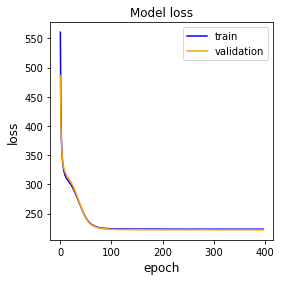

In [22]:
plt.figure(figsize=(4,4))
plt.plot(model.history['loss'], color='blue')
plt.plot(model.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])

In [23]:
# phi = gpmap.x_to_phi(x_test)
# mp_GE.phi_to_yhat(phi)
x_test = test_df['x']
y1_test = test_df['y1']
y2_test = test_df['y2']

In [24]:
# phi = gpmap.x_to_phi(x_test)

# yhat1 = mp_GE_1.phi_to_yhat(phi)
# yhat2 = mp_GE_2.phi_to_yhat(phi)

In [25]:

# fig, axs = plt.subplots(2,2,figsize=(8,8))

# ax = axs[0,0]

# ax.scatter(phi,y1_test,s=3,alpha=0.3,c='blue')
# ax.scatter(phi,yhat1,s=5,alpha=0.9,c='orange',label=f'$g_{1}(\phi)$')

# ax.set_title('Rep-1')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('phi')
# ax.legend()

# ax = axs[0,1]

# ax.scatter(yhat1,y1_test,s=5,alpha=0.3,c='blue')
# ax.set_title('Rep-1')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('yhat-1')


# ax = axs[1,0]
# ax.scatter(phi,y2_test,s=3,alpha=0.3,c='b')
# ax.scatter(phi,yhat2,s=3,alpha=0.9,c='orange',label=f'$g_{2}(\phi)$')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('phi')
# ax.set_title('Rep-2')

# ax = axs[1,1]

# ax.scatter(yhat2,y2_test,s=5,alpha=0.3,c='blue')
# ax.set_title('Rep-2')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('yhat-2')


# fig.tight_layout()

In [26]:
# plt.scatter(yhat1,yhat2)

In [27]:
from mavenn.src.utils import x_to_stats
stats = x_to_stats(x=x_test, alphabet=model.alphabet)
x_ohe_test = stats.pop('x_ohe')

In [43]:
import tensorflow as tf
import tensorflow.keras.backend as K


y_test = np.hstack([y1_test.values.reshape(-1,1),y2_test.values.reshape(-1,1)])

y_hat_functions = []
yhats = []

for _ in range(2):
    y_hat_functions.append(K.function([model.model.layers[0].input], [model.model.layers[2*_+3].output]))
    yhats.append(np.squeeze(y_hat_functions[_](np.hstack([x_ohe_test,y_test]))))

In [40]:
phi_function = K.function([model.model.layers[0].input], [model.model.layers[2].output])
phi = np.squeeze(phi_function(np.hstack([x_ohe_test,y_test])))

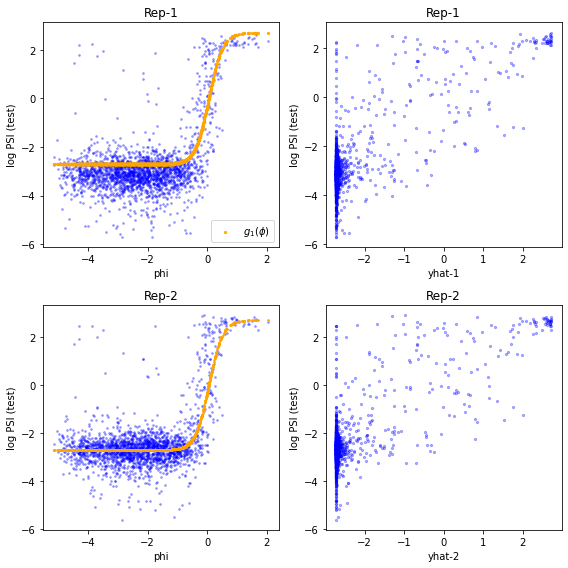

In [53]:

fig, axs = plt.subplots(2,2,figsize=(8,8))

ax = axs[0,0]

ax.scatter(phi,y1_test,s=3,alpha=0.3,c='blue')
ax.scatter(phi,yhats[0],s=5,alpha=0.9,c='orange',label=f'$g_{1}(\phi)$')

ax.set_title('Rep-1')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('phi')
ax.legend()

ax = axs[0,1]

ax.scatter(yhats[0],y1_test,s=5,alpha=0.3,c='blue')
ax.set_title('Rep-1')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('yhat-1')


ax = axs[1,0]
ax.scatter(phi,y2_test,s=3,alpha=0.3,c='b')
ax.scatter(phi,yhats[1],s=3,alpha=0.9,c='orange',label=f'$g_{2}(\phi)$')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('phi')
ax.set_title('Rep-2')

ax = axs[1,1]

ax.scatter(yhats[1],y2_test,s=5,alpha=0.3,c='blue')
ax.set_title('Rep-2')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('yhat-2')


fig.tight_layout()

In [48]:
y_hat_functions_1 = K.function([model.model.layers[0].input], [model.model.layers[3].output])
y_hat_functions_2 = K.function([model.model.layers[0].input], [model.model.layers[5].output])

yhats_1 = np.squeeze(y_hat_functions_1(np.hstack([x_ohe_test,y_test])))
yhats_2 = np.squeeze(y_hat_functions_2(np.hstack([x_ohe_test,y_test])))

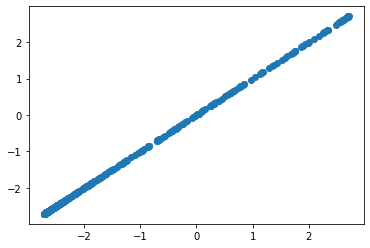

In [51]:
plt.scatter(yhats_1,yhats_2)

array([-2.7075403, -2.7128334, -2.7128232, ..., -2.7102644, -2.7099912,
       -2.713003 ], dtype=float32)